## Imports

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import sys

sys.path.append('..')
from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Add PyalData folder to the path to import all modules

In [2]:
import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

In [3]:
from pyaldata import *

In [4]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

## Load the data

In [5]:
data_dir = "../Data"
fname = os.path.join(data_dir, "Sansa_20180507.mat") #--> only 7 baseline reaches
#fname = os.path.join(data_dir, "Sansa_20180411.mat")



In [6]:
# load TrialData .mat file into a DataFrame
group_df = mat2dataframe(fname, shift_idx_fields=True, td_name='grp')

array field StimParamNames could not be converted to int.


/home/nerea/CL_UpperLimb_Control/PyalData/pyaldata/data_cleaning.py:68: RuntimeWarning: invalid value encountered in cast
  int_arrays = [np.int32(arr) for arr in df[field]]


In [7]:
# trial_df = mat2dataframe_NC(fname, shift_idx_fields=True, td_name = 'trial_data') --> works with data from 07/05
trial_df = mat2dataframe_NC(fname, shift_idx_fields=True, td_name = 'trial_data') 

/home/nerea/CL_UpperLimb_Control/PyalData/pyaldata/data_cleaning.py:68: RuntimeWarning: invalid value encountered in cast
  int_arrays = [np.int32(arr) for arr in df[field]]


array field kin_names could not be converted to int.
array field joint_names could not be converted to int.
array field stim_param_names could not be converted to int.
field idx_sent_pull could not be converted to int.
field idx_bad could not be converted to int.
field idx_decode_reach could not be converted to int.
field idx_sent_reach could not be converted to int.


The main dataframe here is trial_df, the group one will be used if needed to add some variables to the other one.

In [8]:
df = trial_df

`Note` Here not sure if there should be a combination of bins to make it longer and incude more spikes, but I will keep if as the demo, with now 20ms bins. 

#### **Combine time-bins into longer ones**

In [9]:
td = combine_time_bins(df, 2)
# now each bin corresponds to 20ms of recording.

#### **Remove low-firing neurons**

In [10]:
td = remove_low_firing_neurons(td, "M1_spikes",  5)
td = remove_low_firing_neurons(td, "PMd_spikes", 5)

print("original: ", df.M1_spikes[0].shape)
print("removed:  ", td.M1_spikes[0].shape)

original:  (9222, 64)
removed:   (4611, 60)


/home/nerea/CL_UpperLimb_Control/PyalData/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/nerea/CL_UpperLimb_Control/PyalData/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


#### **Transform signals**

In [11]:
td = transform_signal(td, "M1_spikes",  'sqrt')
td = transform_signal(td, "PMd_spikes", 'sqrt')
#here we change the motor and premotor cortex spikes by their square root

#### **Merge signals from multiple areas**

Signals from the pre-motor and motor cortex are now combines in one same variable, we do not consider the 2 regions as different but more as functionally working together.

In [12]:
td = merge_signals(td, ["M1_spikes", "PMd_spikes"], "both_spikes")

print(f"Merging M1 and PMd gives {td.M1_spikes[0].shape[1]} + {td.PMd_spikes[0].shape[1]} = {td.both_spikes[0].shape[1]} neurons")

Merging M1 and PMd gives 60 + 64 = 124 neurons


#### **Calculate firing rates from spikes**

In [13]:
# works on "_spikes" fields and automatically divides by bin_size
td = add_firing_rates(td, 'smooth')

#### **Keep only the successful trials**

#### For this part of the project we do not need perfect reach trials, only to decode the motor intention in baseline trials.

In [14]:
# print("all trials:", td.shape[0])

# #td = select_trials(td, "result == 'R'") --> previously this, not sure if the new "results" column is actually the "file quality"

# td = select_trials(td, "file_quality == 0")

# print("successful trials:", td.shape[0])

In [15]:
td.head(3)

,kin_names,joint_names,bin_size,type,tonic_stim_params,reach_stim_params,pull_stim_params,stim_param_names,file_quality,idx_spike_init,...,angles,pressure,M1_spikes,M1_unit_guide,PMd_spikes,PMd_unit_guide,both_spikes,M1_rates,PMd_rates,both_rates
0,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BASELINE,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[PIN, AMP, PW, FREQ, Length]",0,224,...,"[[131.3609671373651, 62.778435057557694, 129.9...","[-1.1113413890635988, -1.1154173470554491, -1....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[11.223358, 0.6093754, 11.223935, 17.326077, ...","[[0.89774776, 6.201795, 22.478214, 6.412494, 5...","[[11.223358, 0.6093754, 11.223935, 17.326077, ..."
1,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BASELINE,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[PIN, AMP, PW, FREQ, Length]",1,253,...,"[[125.08886683047811, 91.06038841870912, 132.7...","[-1.0971460132308914, -1.1326079009804841, -1....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 6.117056, 0.0, 0.0, 0.014914651, 0.0, 0...","[[8.236052, 1.8339405, 8.251045, 28.87452, 50....","[[0.0, 6.117056, 0.0, 0.0, 0.014914651, 0.0, 0..."
2,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BC-PULL,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 900.0, 0.3, 50.0, 600.0]","[PIN, AMP, PW, FREQ, Length]",0,278,...,"[[129.73603167442403, 54.73211262243076, 120.8...","[-1.1155262707048532, -1.1184089790756042, -1....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.6061999, 0.0, 0.0, 0.6061999, 22.010677, 0...","[[0.6667771, 0.0031754556, 13.162496, 3.020980...","[[0.6061999, 0.0, 0.0, 0.6061999, 22.010677, 0..."


FROM HERE WORK ON DIVIDING TRIALS BY THE DIFFERENT REACHES AND COMBINING ALL TO FEED DECODERS


In [16]:
td.columns

Index(['kin_names', 'joint_names', 'bin_size', 'type', 'tonic_stim_params',
       'reach_stim_params', 'pull_stim_params', 'stim_param_names',
       'file_quality', 'idx_spike_init', 'idx_kuka_go', 'idx_reach',
       'idx_decode_pull', 'idx_sent_pull', 'idx_grab', 'idx_end', 'idx_bad',
       'idx_decode_reach', 'idx_sent_reach', 'x', 'y', 'z', 'angles',
       'pressure', 'M1_spikes', 'M1_unit_guide', 'PMd_spikes',
       'PMd_unit_guide', 'both_spikes', 'M1_rates', 'PMd_rates', 'both_rates'],
      dtype='object')

In [17]:
td['idx_bad']

0              -1
1            2585
2     [711, 5255]
3            2624
4              -1
5              -1
6              -1
7              -1
8              -1
9            1373
10             -1
Name: idx_bad, dtype: object

In [18]:
td['idx_end']

0           [661, 1276, 1840, 2689, 3533]
1                 [670, 1384, 3868, 4664]
2                            [2604, 4519]
3                 [623, 1306, 1918, 3210]
4     [795, 1508, 2181, 2954, 3617, 4204]
5           [630, 1251, 1795, 2438, 3165]
6           [593, 1244, 1918, 2607, 3292]
7                             [614, 1199]
8                 [820, 1424, 3121, 4501]
9                 [672, 2960, 3462, 4031]
10          [649, 1170, 1688, 2175, 2672]
Name: idx_end, dtype: object

In [19]:
td['idx_end_complete'] = td.apply(lambda x: add_bad_idx(x['idx_end'], x['idx_bad']), axis=1)
# Apply the function to each row
td['bad_indices'] = td.apply(find_bad_indices, axis=1)

In [20]:
td['idx_start_test'] = td.idx_reach.apply(lambda x: x[0]).astype('int64')

In [21]:
td['idx_end_test'] = td.idx_end_complete.apply(lambda x: x[0]).astype('int64')

### From here testing to create tydy data and only extract windows for the reaches in each trial

In [22]:
#group_filt = group_df.loc[group_df.Quality == 0].reset_index() --> For now keeping all trials

In [23]:
#td_all = pd.concat([td,group_filt.drop(columns = 'type')], axis = 1)

td_all = pd.concat([td,group_df.drop(columns = 'type')], axis = 1)

In [24]:
group_df.head()

,num,Quality,type,Tonic,Baseline,BCReach,BCPull,BCReachPull,TonicStimParams,ReachStimParams,PullStimParams,KUKAPos,ViconFileName,BlackrockFileName,TDTFileName,StimParamNames
0,4,0,BASELINE,0,1,0,0,0,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[3, 1, 2, 3, 1, 2]",20180507_KRG_BrainDecoding-04.mat,20180507_KRG_BrainDecoding004.nev,Sansa_20180507-4.mat,"[PIN, AMP, PW, FREQ, Length]"
1,5,1,BASELINE,0,1,0,0,0,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[2, 3, 1, 2, 3]",20180507_KRG_BrainDecoding-05.mat,20180507_KRG_BrainDecoding005.nev,Sansa_20180507-5.mat,"[PIN, AMP, PW, FREQ, Length]"
2,6,0,BC-PULL,0,0,0,1,0,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 900.0, 0.3, 50.0, 600.0]","[1, 2, 2, 3, 1, 2]",20180507_KRG_BrainDecoding-06.mat,20180507_KRG_BrainDecoding006.nev,Sansa_20180507-6.mat,"[PIN, AMP, PW, FREQ, Length]"
3,7,0,BC-PULL,0,0,0,1,0,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 1100.0, 0.3, 50.0, 600.0]","[3, 1, 2, 3, 1]",20180507_KRG_BrainDecoding-07.mat,20180507_KRG_BrainDecoding007.nev,Sansa_20180507-7.mat,"[PIN, AMP, PW, FREQ, Length]"
4,8,0,BC-PULL,0,0,0,1,0,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 1200.0, 0.3, 50.0, 600.0]","[2, 3, 1, 2, 3, 1]",20180507_KRG_BrainDecoding-08.mat,20180507_KRG_BrainDecoding008.nev,Sansa_20180507-8.mat,"[PIN, AMP, PW, FREQ, Length]"


In [25]:
td_all

,kin_names,joint_names,bin_size,type,tonic_stim_params,reach_stim_params,pull_stim_params,stim_param_names,file_quality,idx_spike_init,...,BCPull,BCReachPull,TonicStimParams,ReachStimParams,PullStimParams,KUKAPos,ViconFileName,BlackrockFileName,TDTFileName,StimParamNames
0,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BASELINE,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[PIN, AMP, PW, FREQ, Length]",0,224,...,0,0,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[3, 1, 2, 3, 1, 2]",20180507_KRG_BrainDecoding-04.mat,20180507_KRG_BrainDecoding004.nev,Sansa_20180507-4.mat,"[PIN, AMP, PW, FREQ, Length]"
1,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BASELINE,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[PIN, AMP, PW, FREQ, Length]",1,253,...,0,0,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[2, 3, 1, 2, 3]",20180507_KRG_BrainDecoding-05.mat,20180507_KRG_BrainDecoding005.nev,Sansa_20180507-5.mat,"[PIN, AMP, PW, FREQ, Length]"
2,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BC-PULL,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 900.0, 0.3, 50.0, 600.0]","[PIN, AMP, PW, FREQ, Length]",0,278,...,1,0,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 900.0, 0.3, 50.0, 600.0]","[1, 2, 2, 3, 1, 2]",20180507_KRG_BrainDecoding-06.mat,20180507_KRG_BrainDecoding006.nev,Sansa_20180507-6.mat,"[PIN, AMP, PW, FREQ, Length]"
3,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BC-PULL,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 1100.0, 0.3, 50.0, 600.0]","[PIN, AMP, PW, FREQ, Length]",0,221,...,1,0,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 1100.0, 0.3, 50.0, 600.0]","[3, 1, 2, 3, 1]",20180507_KRG_BrainDecoding-07.mat,20180507_KRG_BrainDecoding007.nev,Sansa_20180507-7.mat,"[PIN, AMP, PW, FREQ, Length]"
4,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BC-PULL,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 1200.0, 0.3, 50.0, 600.0]","[PIN, AMP, PW, FREQ, Length]",0,440,...,1,0,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 1200.0, 0.3, 50.0, 600.0]","[2, 3, 1, 2, 3, 1]",20180507_KRG_BrainDecoding-08.mat,20180507_KRG_BrainDecoding008.nev,Sansa_20180507-8.mat,"[PIN, AMP, PW, FREQ, Length]"
5,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BC-PULL,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 1200.0, 0.3, 50.0, 600.0]","[PIN, AMP, PW, FREQ, Length]",0,252,...,1,0,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 1200.0, 0.3, 50.0, 600.0]","[2, 3, 1, 2, 3]",20180507_KRG_BrainDecoding-09.mat,20180507_KRG_BrainDecoding009.nev,Sansa_20180507-9.mat,"[PIN, AMP, PW, FREQ, Length]"
6,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BC-PULL,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 1200.0, 0.3, 80.0, 600.0]","[PIN, AMP, PW, FREQ, Length]",0,277,...,1,0,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 1200.0, 0.3, 80.0, 600.0]","[1, 2, 3, 1, 2]",20180507_KRG_BrainDecoding-10.mat,20180507_KRG_BrainDecoding010.nev,Sansa_20180507-10.mat,"[PIN, AMP, PW, FREQ, Length]"
7,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BASELINE,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[PIN, AMP, PW, FREQ, Length]",0,228,...,0,0,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[3, 1]",20180507_KRG_BrainDecoding-11.mat,20180507_KRG_BrainDecoding011.nev,Sansa_20180507-11.mat,"[PIN, AMP, PW, FREQ, Length]"
8,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BC-PULL,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 1200.0, 0.3, 80.0, 600.0]","[PIN, AMP, PW, FREQ, Length]",0,315,...,1,0,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]",

In [26]:
td.head()

,kin_names,joint_names,bin_size,type,tonic_stim_params,reach_stim_params,pull_stim_params,stim_param_names,file_quality,idx_spike_init,...,PMd_spikes,PMd_unit_guide,both_spikes,M1_rates,PMd_rates,both_rates,idx_end_complete,bad_indices,idx_start_test,idx_end_test
0,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BASELINE,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[PIN, AMP, PW, FREQ, Length]",0,224,...,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[11.223358, 0.6093754, 11.223935, 17.326077, ...","[[0.89774776, 6.201795, 22.478214, 6.412494, 5...","[[11.223358, 0.6093754, 11.223935, 17.326077, ...","[661, 1276, 1840, 2689, 3533]","[0, 0, 0, 0, 0]",596,661
1,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BASELINE,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[PIN, AMP, PW, FREQ, Length]",1,253,...,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 6.117056, 0.0, 0.0, 0.014914651, 0.0, 0...","[[8.236052, 1.8339405, 8.251045, 28.87452, 50....","[[0.0, 6.117056, 0.0, 0.0, 0.014914651, 0.0, 0...","[670, 1384, 2585, 3868, 4664]","[0, 0, 1, 0, 0]",609,670
2,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BC-PULL,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 900.0, 0.3, 50.0, 600.0]","[PIN, AMP, PW, FREQ, Length]",0,278,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.6061999, 0.0, 0.0, 0.6061999, 22.010677, 0...","[[0.6667771, 0.0031754556, 13.162496, 3.020980...","[[0.6061999, 0.0, 0.0, 0.6061999, 22.010677, 0...","[711, 2604, 4519, 5255]","[1, 0, 0, 1]",485,711
3,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BC-PULL,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 1100.0, 0.3, 50.0, 600.0]","[PIN, AMP, PW, FREQ, Length]",0,221,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 17.063677, 0.0, 0.0, 14.686952, 6.16206...","[[0.0, 0.059919834, 2.1389797, 19.27935, 48.34...","[[0.0, 17.063677, 0.0, 0.0, 14.686952, 6.16206...","[623, 1306, 1918, 2624, 3210]","[0, 0, 0, 1, 0]",567,623
4,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BC-PULL,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 1200.0, 0.3, 50.0, 600.0]","[PIN, AMP, PW, FREQ, Length]",0,440,...,"[[0.0, 1.0, 1.4142135623730951, 1.732050807568...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 11.268363, 0.0031754556, 0.0, 26.240406...","[[13.174155, 32.673943, 55.984524, 59.49532, 3...","[[0.0, 11.268363, 0.0031754556, 0.0, 26.240406...","[795, 1508, 2181, 2954, 3617, 4204]","[0, 0, 0, 0, 0, 0]",708,795


In [27]:
cols_to_search = ['index', 'num', 'type', 'KUKAPos', 
               'idx_kuka_go', 'idx_reach', 'idx_end_complete',
               'bad_indices', 'x', 'y', 'z', 'angles', 'both_spikes', 'both_rates', 'file_quality']
cols_to_keep = [c for c in cols_to_search if c in td_all.columns]
td_filt = td_all[cols_to_keep]


In [28]:
td_filt = td_filt.loc[td_filt.type == 'BASELINE'].reset_index()
td_filt = td_filt.loc[td_filt.file_quality == 0].reset_index()

In [29]:
td_filt['test_start'] = td_filt['idx_reach'].apply(lambda x: x[0])

In [30]:
td_filt['test_end'] = td_filt['idx_end_complete'].apply(lambda x: x[0])

In [31]:
win_df = split_time_fields(td_filt, start_margin = 5, end_margin = 10)

`Note`angle 3 is better to visualize X data and angle 4 for Y data.

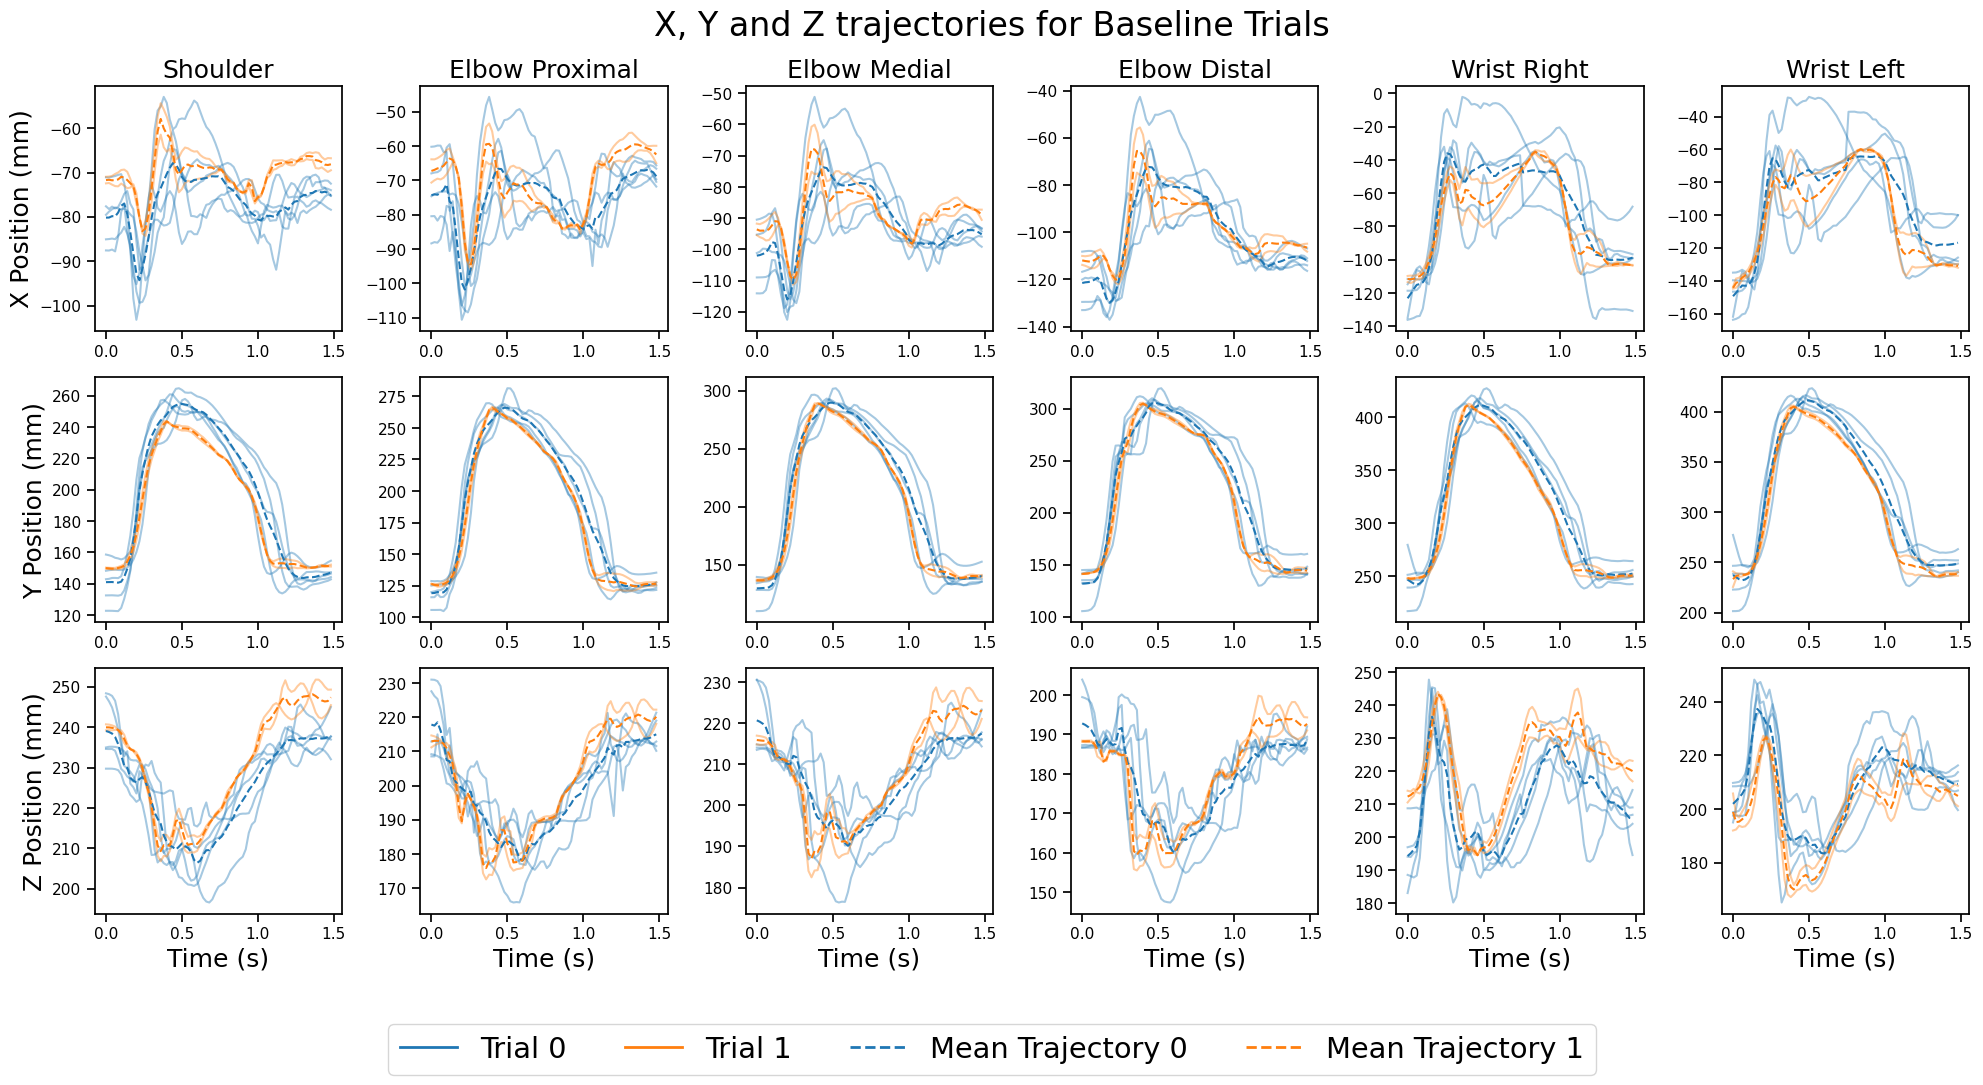

In [56]:
# Visualize the trajectories, split by reach trial
visualize_traj(win_df, ['x', 'y', 'z'], marker_names = ['Shoulder',	'Elbow Proximal', 'Elbow Medial', 'Elbow Distal', 'Wrist Right',	'Wrist Left'])  # Replace df with your actual DataFrame containing trajectory data

In [33]:
win_df['angles'] = np.nan_to_num(win_df['angles'], nan = 0)

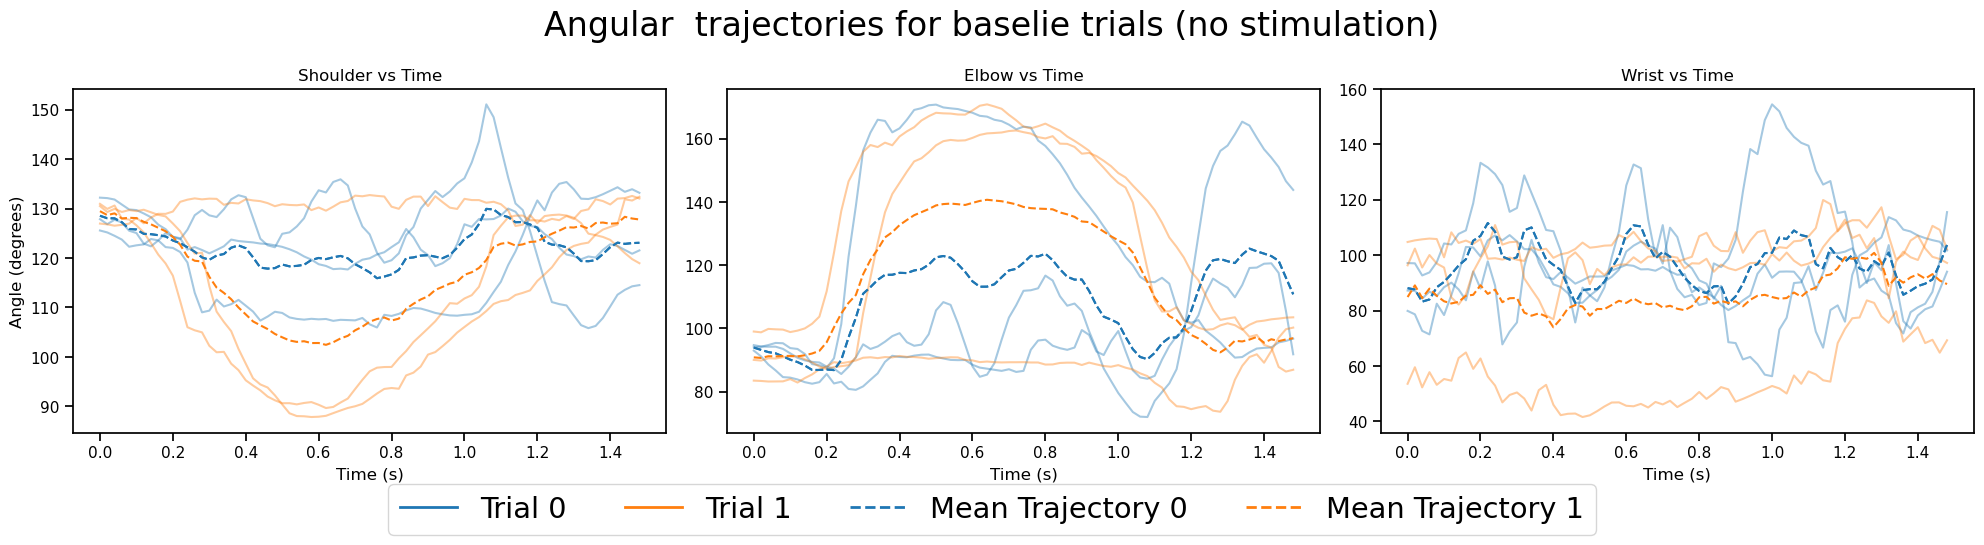

In [34]:
visualize_angles(win_df, 'angles',  angle_names = ['Shoulder', 'Elbow', 'Wrist'])

In [35]:
tidy_df = build_tidy_df(td_filt, start_margin = 5)

In [37]:
tidy_df.head(2)

,num,type,trial_num,reach_num,time_sample,x,y,z,angles,both_spikes,both_rates
0,2,BASELINE,0,0,0,"[141.9524688720703, 117.76282501220703, 139.16...","[65.41489028930664, 99.49823760986328, 115.036...","[237.76589965820312, 200.17157745361328, 202.2...","[125.56201945487668, 92.97474431295734, 79.900...","[0.0, 1.0, 1.7320508075688772, 0.0, 1.0, 0.0, ...","[5.9548197, 45.886963, 68.468704, 18.417976, 5..."
1,2,BASELINE,0,0,1,"[141.61994171142578, 117.60234832763672, 138.8...","[65.34469223022461, 99.77312850952148, 114.737...","[237.94485473632812, 200.23880767822266, 203.0...","[125.17232086368108, 91.1445968398082, 78.6559...","[0.0, 1.0, 1.4142135623730951, 0.0, 1.73205080...","[4.343852, 45.023403, 62.56575, 21.267706, 55...."


### Data augmentation for linear decoders

Data augmentation to account for the neural activity up to 100ms before the position/movement. 
We build 5 new timeseries, each one starting 20ms after. We pad the data using the first sample.

In [38]:
tidy_df['both_rates_1'] = pd.concat([tidy_df.both_rates[:1], tidy_df.both_rates[:-1]]).reset_index().drop(columns = 'index')
tidy_df['both_rates_2'] = pd.concat([tidy_df.both_rates[:1],tidy_df.both_rates[:1],  tidy_df.both_rates[:-2]]).reset_index().drop(columns = 'index')
tidy_df['both_rates_3'] = pd.concat([tidy_df.both_rates[:1],tidy_df.both_rates[:1],tidy_df.both_rates[:1],  tidy_df.both_rates[:-3]]).reset_index().drop(columns = 'index')
tidy_df['both_rates_4'] = pd.concat([tidy_df.both_rates[:1],tidy_df.both_rates[:1], tidy_df.both_rates[:1],tidy_df.both_rates[:1], tidy_df.both_rates[:-4]]).reset_index().drop(columns = 'index')
tidy_df['both_rates_5'] = pd.concat([tidy_df.both_rates[:1],tidy_df.both_rates[:1], tidy_df.both_rates[:1],tidy_df.both_rates[:1], tidy_df.both_rates[:1], tidy_df.both_rates[:-5]]).reset_index().drop(columns = 'index')

In [39]:
def extend_cols(x, main_col, cols):
    data = x[main_col]
    for c in cols:
        data = np.concatenate([data, x[c]])
    return data

In [40]:
tidy_df['both_rates_augmented'] = tidy_df[['both_rates', 'both_rates_1', 
                                      'both_rates_2', 'both_rates_3', 
                                      'both_rates_4', 'both_rates_5']].apply(lambda x: extend_cols(x, 'both_rates', 
                                                                                                   ['both_rates_1', 'both_rates_2', 
                                                                                                    'both_rates_3', 'both_rates_4', 
                                                                                                    'both_rates_5']), axis = 1)

In [41]:
tidy_df['target_pos'] = tidy_df.apply(lambda x: np.concatenate([x['x'][4:5], x['y'][4:5], x['z'][4:5]]), axis = 1)

#### **Further preprocess by subtracting cross-condition mean**

In [42]:
# aka center per time point
move_td = subtract_cross_condition_mean(tidy_df) # --> maybe not needed here, I'll still standardize data later

In [43]:
tidy_df['id'] = tidy_df['trial_num'].astype(str) + '_' + tidy_df['reach_num'].astype(str)

In [44]:
tidy_df['id'].nunique()

57

We now want to split this data into training-validation-test by doing:

- split by reach_number 
- maximum amount of trial numbers represented in the validation/test data 
- homogeneous distribution of the KUKAPos is possible (changes the trajectory, so that the model does not learn only 1 specific trajectory) 
- Here the type is always BASELINE, as it is the first model, then we will decide if we train also using BC-PULL data or we only test on that.

Now the next question is "What do we want to predict exactly?"

Options:

- Predict only x or y vector with all markers.
- Predict a vector combining all markers for all directions.
- Create an additional variable, combining all the previous information.
- Predict the angles instead of the marker positions.


For the first model let's say we use only "both_rates" as X matrix and "x" position (including all markers) as target (or y). 

In [45]:
X_train, y_train, X_val, y_val, X_test, y_test, info_train, info_val, info_test, mins, maxs = train_test_split(tidy_df, train_variable = 'both_rates_augmented', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)

Train trials 37
Test trials  11
Val trials 9


Here we want to analyse the target distribution.
We will use fold 0 as an example, as we expect the rest to be similar.

In [46]:
y_test_dist = y_test['fold0']

0  mean  328.7858487030954  median  334.1112060546875  mode  [362.522, 370.303, 211.489, 211.337, 211.301]  std dev  68.68934646073593
1  mean  70.67439048602725  median  59.48752975463867  mode  [20.706, 85.494]  std dev  36.646779179530405
2  mean  208.54347549900865  median  209.06653594970703  mode  [237.987, 196.859, 228.397, 201.467, 186.088, 210.46, 238.674]  std dev  19.55151657900667


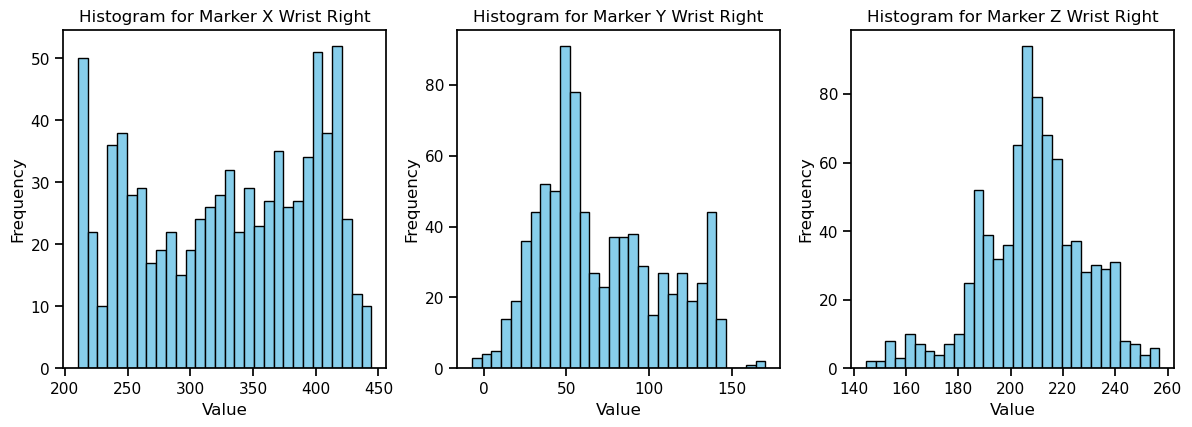

In [47]:
# Get the number of markers (features)
num_markers = y_test_dist.shape[1]

# Plot histograms for each marker
plt.figure(figsize=(12, 8))
#marker_names =  ['Shoulder',	'Elbow Proximal',	'Elbow Medial',	'Elbow Distal',	'Wrist Right',	'Wrist Left']
marker_names = ['X Wrist Right', 'Y Wrist Right', 'Z Wrist Right']
for i in range(num_markers):
    plt.subplot(2, 3, i+1)  # Adjust the subplot layout as needed
    plt.hist(y_test_dist[:, i], bins=30, color='skyblue', edgecolor='black')
    print(i, ' mean ', np.mean(y_test_dist[:,i]), ' median ', np.median(y_test_dist[:,i]), ' mode ', calculate_mode(y_test_dist[:,i]), ' std dev ', np.std(y_test_dist[:,i]))
    #skewness, and kurtosis
    plt.title(f'Histogram for Marker {marker_names[i]}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Explanation of what function to use as activation for my LSTM based on the data description and analysis:

If your output represents a 0-1 distribution that is left-skewed but gradually increases towards the right, you would typically want to use an activation function that can handle bounded outputs and is capable of capturing non-linear relationships. In this scenario, the best choice of activation function after the second linear layer could be the **sigmoid activation function**.

The sigmoid function has the following properties:

- *Bounded Output*: The output of the sigmoid function is bounded between 0 and 1, which aligns with your distribution.

- *Non-linearity*: The sigmoid function introduces non-linearity to the model, allowing it to capture complex relationships between features and outputs.

- *Smooth Gradient*: The sigmoid function has a smooth gradient, which facilitates stable training via backpropagation.

## Ridge Regression

In [48]:
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA, FactorAnalysis

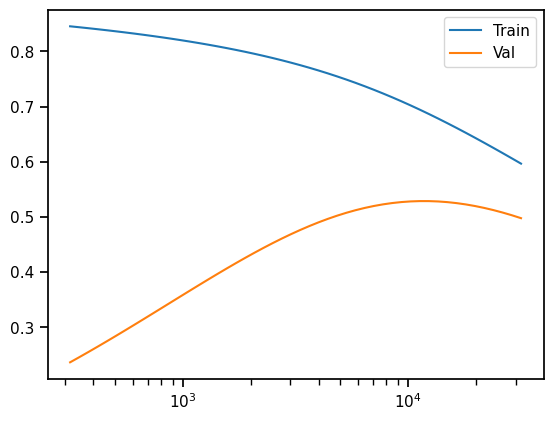

In [49]:
num_folds = 5
dim_reduce = False
num_dim = 10

alphas = np.logspace(2.5, 4.5, 50)

test_score = []
train_score = []
best_a = []

for i in range(num_folds):
    train_score_a = []
    val_score_a = []

    best_score = -np.inf  # Initialize best score to negative infinity
    best_model = None

    for a in alphas:
        if dim_reduce == True:

            PCA_model = PCA(num_dim).fit(X_train['fold'+str(i)])
            X_train_ = PCA_model.transform(X_train['fold'+str(i)])
            X_val_ = PCA_model.transform(X_val['fold'+str(i)])
            X_test_ = PCA_model.transform(X_test['fold'+str(i)])
        else:
            X_train_ = X_train['fold'+str(i)]
            X_val_ = X_val['fold'+str(i)]
            X_test_ = X_test['fold'+str(i)]

        model = Ridge(alpha = a, fit_intercept=True)
        model.fit(X_train_, y_train['fold'+str(i)])
        score = model.score(X_val_, y_val['fold'+str(i)])
        train_score_a.append(model.score(X_train_, y_train['fold'+str(i)]))
        val_score_a.append(score)

        # Check if current model has better validation score than previous best
        if score > best_score:
            best_score = score
            best_model = model
    if i == 1:
        plt.plot(alphas, train_score_a, label = 'Train')
        plt.plot(alphas, val_score_a, label = 'Val')
        plt.xscale('log')
        plt.legend()

    best_a.append(alphas[np.argmax(val_score_a)])
    test_score.append(best_model.score(X_test_, y_test['fold'+str(i)]))
    train_score.append(best_model.score(X_train_, y_train['fold'+str(i)]))


In [50]:
best_a

[3314.4247494664246,
 11246.578221198195,
 4393.97056076079,
 3999.823395608933,
 3999.823395608933]

In [51]:
train_score

[0.7620144047811328,
 0.6943864171961959,
 0.7266067581948116,
 0.7680808953186505,
 0.7497925790830225]

In [52]:
test_score

[0.6224326917449406,
 0.5587507109505842,
 0.6138388451923618,
 0.5844192020112887,
 0.5939640815656086]

Fold  0   0 % gridsearch
Fold  0   0 % gridsearch
Fold  0   1 % gridsearch
Fold  0   2 % gridsearch
Fold  0   3 % gridsearch
Fold  0   4 % gridsearch
Fold  0   5 % gridsearch
Fold  0   5 % gridsearch
Fold  0   6 % gridsearch
Fold  0   7 % gridsearch
Fold  0   8 % gridsearch
Fold  0   9 % gridsearch
Fold  0   10 % gridsearch
Fold  0   10 % gridsearch
Fold  0   11 % gridsearch
Fold  0   12 % gridsearch
Fold  0   13 % gridsearch
Fold  0   14 % gridsearch
Fold  0   15 % gridsearch
Fold  0   15 % gridsearch
Fold  0   16 % gridsearch
Fold  0   17 % gridsearch
Fold  0   18 % gridsearch
Fold  0   19 % gridsearch
Fold  0   20 % gridsearch
Fold  0   20 % gridsearch
Fold  0   21 % gridsearch
Fold  0   22 % gridsearch
Fold  0   23 % gridsearch
Fold  0   24 % gridsearch
Fold  0   25 % gridsearch
Fold  0   25 % gridsearch
Fold  0   26 % gridsearch
Fold  0   27 % gridsearch
Fold  0   28 % gridsearch
Fold  0   29 % gridsearch
Fold  0   30 % gridsearch
Fold  0   30 % gridsearch
Fold  0   31 % gridsearc

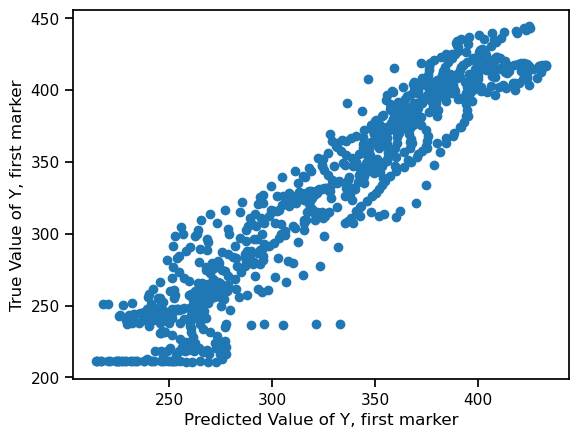

In [53]:
from itertools import product

num_folds = 5
dim_reduce = True
num_dim = 10

alphas = np.logspace(2, 3.7, 20)
pca_dimensions = [100, 110, 120, 130, 140, 150]  # Define the PCA dimensions to search over

test_score = []
train_score = []
best_a_list = []
best_dim_list = []

# Define the grid of parameters to search over
param_grid = list(product(alphas, pca_dimensions))

for i in range(num_folds):
    
    train_score_a = []
    val_score_a = []

    best_score = -np.inf  # Initialize best score to negative infinity
    best_model = None
    best_a = 0
    best_dim = 5

    j = 0
    for a, dim in param_grid:
        print('Fold ', i, ' ', int((j/len(param_grid))*100) , '% gridsearch')
        if dim_reduce == True:
            PCA_model = PCA(dim).fit(X_train['fold'+str(i)])
            X_train_ = PCA_model.transform(X_train['fold'+str(i)])
            X_val_ = PCA_model.transform(X_val['fold'+str(i)])
            X_test_ = PCA_model.transform(X_test['fold'+str(i)])


        model = Ridge(alpha=a, fit_intercept=True)
        model.fit(X_train_, y_train['fold'+str(i)])
        score = model.score(X_val_, y_val['fold'+str(i)])
        train_score_a.append(model.score(X_train_, y_train['fold'+str(i)]))
        val_score_a.append(score)

        # Check if current model has better validation score than previous best
        if score > best_score:
            best_score = score
            best_model = model
            best_a = a  # Update best alpha
            best_dim = dim  # Update best PCA dimension
        j+=1

    best_a_list.append(best_a)
    best_dim_list.append(best_dim)
    PCA_model = PCA(best_dim).fit(X_train['fold'+str(i)])
    X_train_ = PCA_model.transform(X_train['fold'+str(i)])
    X_val_ = PCA_model.transform(X_val['fold'+str(i)])
    X_test_ = PCA_model.transform(X_test['fold'+str(i)])
    model = Ridge(alpha=best_a, fit_intercept=True)
    model.fit(X_train_, y_train['fold'+str(i)])
    test_score.append(model.score(X_test_, y_test['fold'+str(i)]))
    train_score.append(model.score(X_train_, y_train['fold'+str(i)]))
    if i == 0:
        plt.scatter(model.predict(X_test_)[:,0], y_test['fold'+str(i)][:,0])
        plt.ylabel('True Value of Y, first marker')
        plt.xlabel('Predicted Value of Y, first marker')


In [54]:
best_a_list

[784.7599703514614,
 5011.872336272725,
 4078.742758969022,
 2701.3381211330047,
 4078.742758969022]

In [55]:
best_dim_list

[100, 100, 140, 140, 130]

In [56]:
test_score

[0.6016299906053667,
 0.5624500790710669,
 0.6072479064629417,
 0.5798140769493323,
 0.5968539716939593]

In [57]:
np.mean(test_score)

0.5895992049565335

In [58]:
train_score

[0.7509702897502892,
 0.7305221994096435,
 0.7165497012734084,
 0.7688958002959883,
 0.7330727066373736]

## LSTM

In [59]:
# path_to_save_data = './Data/Processed_Data/Tidy_Sansa_11_04.pkl'

In [60]:
""" with open(path_to_save_data, 'wb') as handle:
            pickle.dump(tidy_df, handle, protocol=4) """

" with open(path_to_save_data, 'wb') as handle:\n            pickle.dump(tidy_df, handle, protocol=4) "

In [61]:
data_path = './Data/Processed_Data/Tidy_Sansa_0411.pkl'

with open(data_path, 'rb') as file:
    tidy_df = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: './Data/Processed_Data/Tidy_Sansa_0411.pkl'

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, info_train, info_val, info_test, mins, maxs = train_test_split(tidy_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_vel', num_folds = 5)

Test trials  11
Val trials 9


In [ ]:
# Test one of the folds first
fold_num = 'fold0'
fold = 0

print('We are testing the optimization method on fold ', fold)


X_train = X_train[fold_num]
X_val = X_val[fold_num]
X_test = X_test[fold_num]
y_test = y_test[fold_num]
y_train = y_train[fold_num]
y_val = y_val[fold_num]


# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda:0') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

num_dim_output = y_train.shape[1]
num_features = X_train.shape[1]

seq_length = 75

# Reshape x_train to match the number of columns in the model's input layer
xx_train = X_train.reshape(X_train.shape[0] // seq_length, seq_length, X_train.shape[1])  
# Reshape y_train to match the number of neurons in the model's output layer
yy_train = y_train.reshape(y_train.shape[0] // seq_length, seq_length, y_train.shape[1])  

xx_val = X_val.reshape(X_val.shape[0] // seq_length, seq_length, X_val.shape[1])  
yy_val = y_val.reshape(y_val.shape[0] // seq_length, seq_length, y_val.shape[1])  

xx_test = X_test.reshape(X_test.shape[0] // seq_length, seq_length, X_test.shape[1])  
yy_test = y_test.reshape(y_test.shape[0] // seq_length, seq_length, y_test.shape[1])  

seed = 42
torch.manual_seed(seed)

We are testing the optimization method on fold  0


In [ ]:
class Model(nn.Module):
    def __init__(self, num_features=124, 
                hidden_units= 3, #was 128
                num_layers = 2, 
                out_dims = 6,
                dropout = 0.5):
        super(Model, self).__init__()
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.out_dims = out_dims
        self.dropout = dropout

        self.rnn = nn.RNN(
            input_size = self.num_features, 
            hidden_size = self.hidden_units, 
            num_layers = self.num_layers, 
            nonlinearity='tanh', bias= True, 
            batch_first= True, dropout=0.0, 
            bidirectional=False,) 
        
        """ self.lstm = nn.LSTM(
            input_size= self.num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers= num_layers,
            bidirectional=False,) """
        
        self.selu = nn.SELU()
    
        self.linear = nn.Linear(in_features=self.hidden_units, out_features= self.out_dims)

        self.dropout = nn.Dropout(p= dropout) #trial.suggest_float('dropout_1', 0.1, 0.9)
        
        # Flatten the parameters
        self.rnn.flatten_parameters()

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.dropout(x)
        x = self.selu(x) 
        output = self.linear(x)


        
        return output.squeeze()

In [ ]:
# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1e-5
l1_ratio_reg = 0.5

lr = 0.00001
loss_function = huber_loss
delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
hidden_units = 100
num_layers = 1
input_size = 49
dropout = 0.2

#Other training hyperparameters

lr_gamma= 1.37 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 19
batch_size_train= 15
batch_size_val = 15

In [ ]:
# Fit the LSTM model
model = Model(num_features=num_features, 
                    hidden_units= hidden_units, #was 128
                    num_layers = num_layers, 
                    out_dims = num_dim_output, 
                    dropout = dropout ).to(device)

In [ ]:
train_losses, val_losses = \
    train_model(model, xx_train,yy_train,
                xx_val, 
                yy_val,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer = Regularizer_RNN,
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 15,
                
                )

Epoch 000 Train 0.0981 Val 0.0681
Epoch 001 Train 0.0776 Val 0.0556
Epoch 002 Train 0.0652 Val 0.0479
Epoch 003 Train 0.0568 Val 0.0427
Epoch 004 Train 0.0508 Val 0.0387
Epoch 005 Train 0.0460 Val 0.0355
Epoch 006 Train 0.0421 Val 0.0329
Epoch 007 Train 0.0388 Val 0.0307
Epoch 008 Train 0.0361 Val 0.0288
Epoch 009 Train 0.0337 Val 0.0271
Epoch 010 Train 0.0312 Val 0.0252
Epoch 011 Train 0.0286 Val 0.0235
Epoch 012 Train 0.0265 Val 0.0221
Epoch 013 Train 0.0248 Val 0.0208
Epoch 014 Train 0.0233 Val 0.0198
Epoch 015 Train 0.0221 Val 0.0188
Epoch 016 Train 0.0209 Val 0.0180
Epoch 017 Train 0.0199 Val 0.0173
Epoch 018 Train 0.0191 Val 0.0167
Epoch 019 Train 0.0183 Val 0.0162
Epoch 020 Train 0.0176 Val 0.0156
Epoch 021 Train 0.0169 Val 0.0151
Epoch 022 Train 0.0164 Val 0.0148
Epoch 023 Train 0.0159 Val 0.0145
Epoch 024 Train 0.0157 Val 0.0143
Epoch 025 Train 0.0154 Val 0.0142
Epoch 026 Train 0.0153 Val 0.0141
Epoch 027 Train 0.0152 Val 0.0141
Epoch 028 Train 0.0151 Val 0.0141
Epoch 029 Trai

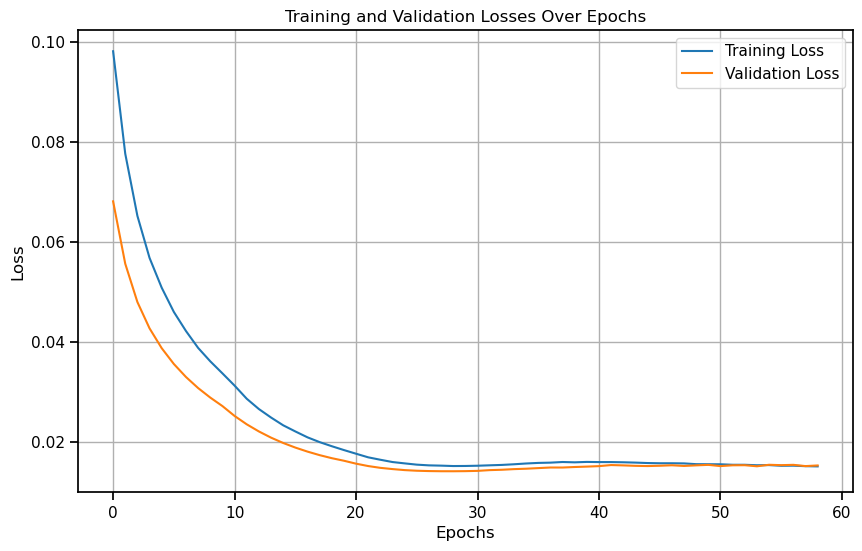

In [ ]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [ ]:
""" path_to_models = './Models'
experiment_name = 'Fold0_BaselineData_LSTM_20180411'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4) """

" path_to_models = './Models'\nexperiment_name = 'Fold0_BaselineData_LSTM_20180411'\npath_to_save_model = os.path.join(path_to_models,experiment_name)\nif not os.path.exists(path_to_save_model):\n            os.makedirs(path_to_save_model)\npath_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))\ntorch.save(model, path_to_save_model_fold)\ndict_loss = {}\ndict_loss['train'] = train_losses\ndict_loss['val'] = val_losses\npath_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))\nwith open(path_to_save_model_losses, 'wb') as handle:\n    pickle.dump(dict_loss, handle, protocol=4) "

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model, metric = 'ev')

Train EV: 0.37 
Val EV: 0.31 
Test EV: 0.38 


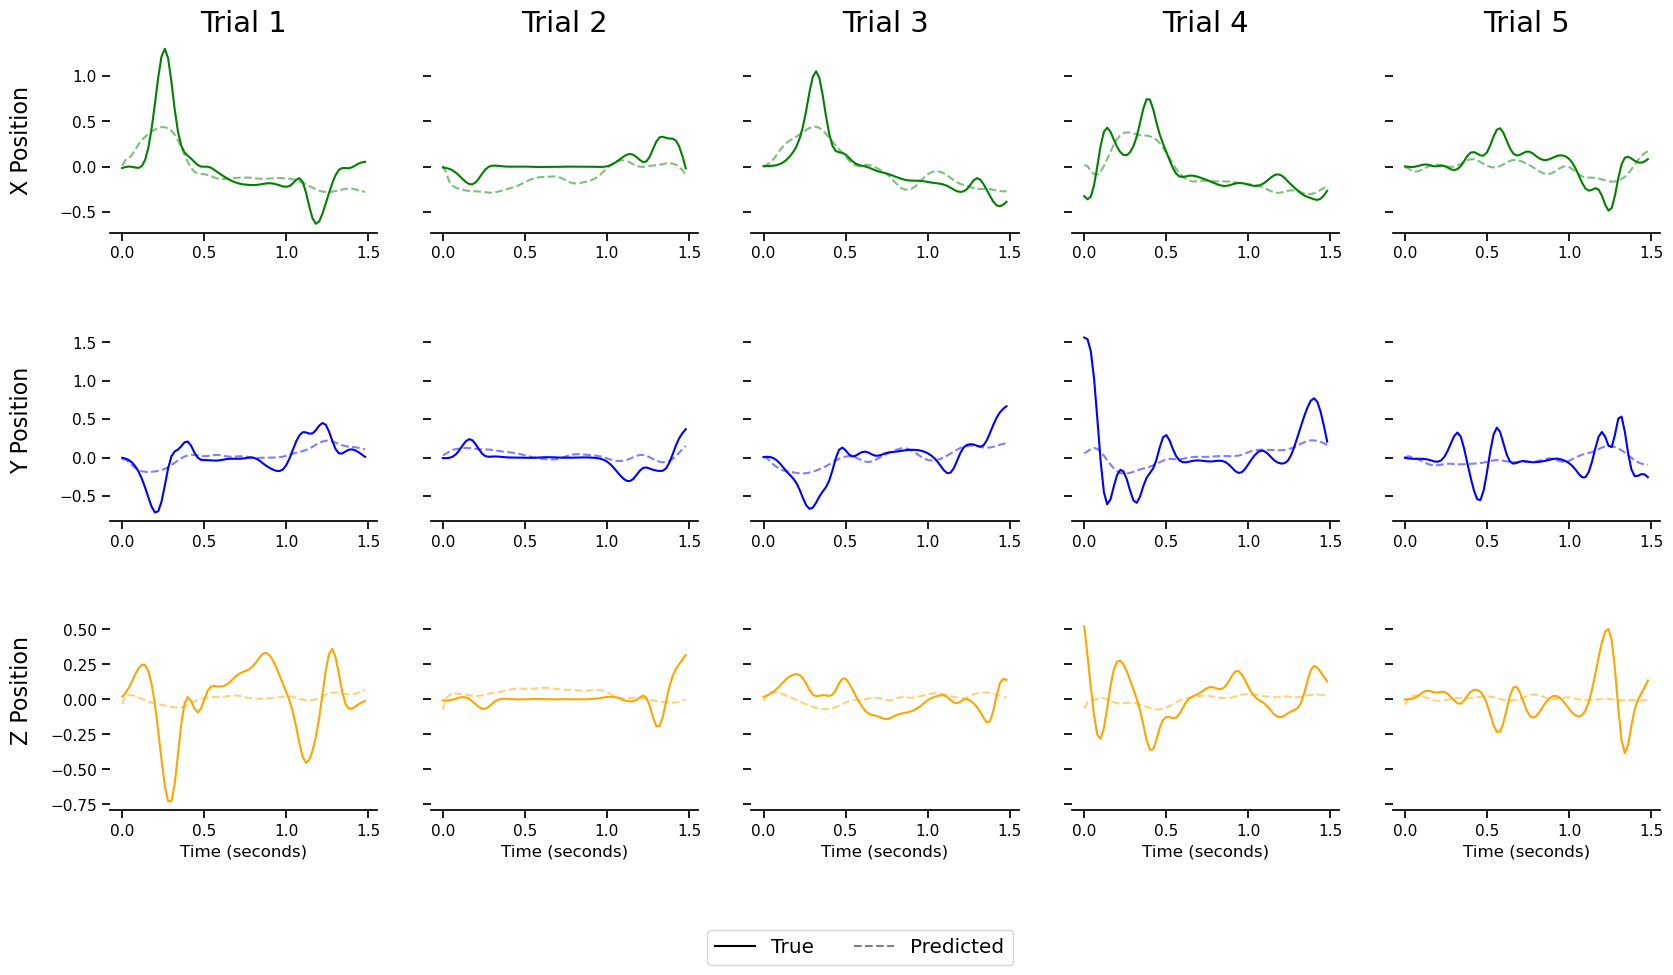

In [ ]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)